# OLS
- 작성자: 고려대학교 경제학과 한치록 교수

## 도입

Python을 이용한 OLS 방법에 대하여 설명한다. 수학적으로 OLS는 $(X'X)^{-1} X'y$ 식을 이용하면 간단하지만, 실수를 저지를 가능성을 고려할 때 연산을 직접 수행하는 것은 가급적 피하는 것이 좋다. 데이터셋이 결측치를 포함하고 있으면 특히 그렇다. OLS와 같은 정형화된 분석에서 수동으로 코딩을 하는 것은 결측치, [collinearity 문제의 처리][ls/col]가 제대로 되었는지 확인하기 어려우므로 특별한 목적(주로 학습 목적)이 아니라면 권장되지 않는다. 그보다는 [statsmodels][sm] 패키지를 활용하는 것이 간편하다. 하지만 [statsmodels][sm]도 공선성 처리 부분이 부정확하다. bok_da 라이브러리는 공선성 점검과 여타 결과 리포트 관련 개선을 하기 위하여 monkey patch된 [statsmodels][sm] 패키지를 제공한다.

monkey patch된 `statsmodels` 패키지와 원래 `statsmodels` 패키지의 가장 큰 차이점은 collinearity를 점검하고 필요에 따라 변수를 누락시킨다는 것이다. 이로써 [Stata]나 [R]과 동일한 수준으로 정교한 선형회귀를 구현할 수 있다. 또한 자동화된 WLS, Prais-Winsten 추정, 몇몇 선형패널 모형 추정을 할 수 있는 방법들을 추가로 제공한다. (도구변수 추정은 [linearmodels][lm] 패키지에 필수적인 monkey patch를 적용하여 구현하였다. 이를 위해서는 본 라이브러리인 `bok_da` 라이브러리를 import하여야 한다. 이에 대해서는 나중에 도구변수 추정 부분에서 설명한다. [Statsmodels][sm] 패키지에서도 도구변수 추정을 위한 모듈을 제공하는 것은 사실이나 현 버전 0.15에서는 실무에 활용할 수 있는 수준이 아니다.)

OLS 추정 결과의 presentation을 위해 그림이 많이 사용될 것인데, 그림을 그리는 데에는 [matplotlib][mpl]을 사용할 수 있다. t분포 등 관련해서는 [SciPy][scipy] 패키지가 필요하다. 지수함수 변환, 로그 변환 등에는 [NumPy][np]가 필요하다. 아직 설치되지 않았으면 다음 명령으로 모듈들을 설치한다. 콘다 환경이라면 `pip` 대신에 `conda` 관련 shell 명령을 사용해야 할 것이다(BIDAS 파이썬 분석환경은 이미 설치되어 있어 따로 신경쓸 필요 없다).

```sh
pip install numpy matplotlib scipy
```

이미 설치되어 있는 패키지도 있을 것인데 중복해서 설치할 필요는 없다. 패키지가 설치되어 있는지 확인하려면 `pip show numpy` 등으로 확인 가능하다. 콘다의 경우에는 `conda list numpy` 등을 사용할 수 있다. 아니면 파이썬 내에서 `import numpy as np`와 같이 해서 오류 메시지가 안 나오면 제대로 설치되어 있는 것이다.

[R]: https://r-project.org/
[Stata]: https://stata.com/
[np]: https://numpy.org/
[sm]: https://www.statsmodels.org/
[lm]: https://bashtage.github.io/linearmodels/
[mpl]: https://matplotlib.org
[scipy]: https://scipy.org
[ols]: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
[olsf]: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html
[ls/col]: 03%20Collinearity.ipynb

### Statasmodels 인터페이스

[Statsmodels][sm]에서 OLS는 (i) [행렬들을 인자로 사용하는 인터페이스][ols]와 (ii) [R]의 [formula](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/formula.html)처럼 간편하게 [수식을 활용하는 인터페이스][olsf]로써 구현할 수 있다. 행렬을 사용할 때에는 다음과 같이 한다.

```python
import statsmodels.api as sm
sm.OLS(y,X).fit() # X contains a constant column for intercept
```

Formula 인터페이스를 사용할 때에는 (데이터 프레임 `df`에 데이터가 있다는 가정하에)

```python
import statsmodels.api as sm
sm.OLS.from_formula("y ~ x1 + x2", data = df).fit() # constant is automatically added
```

와 같이 하거나, 더 짧게

```python
import statsmodels.formula.api as smf
smf.ols("y ~ x1 + x2", data = df).fit()
```

와 같이 한다. 행렬을 직접 사용하기 위해서는 절편을 위한 상수항을 추가해 주어야 하는 등 복잡하여 실수를 저지르기 쉬우므로 가급적 수식을 사용한 인터페이스를 사용할 것을 권장한다.

[R]: https://r-project.org/
[Stata]: https://stata.com/
[np]: https://numpy.org/
[sm]: https://www.statsmodels.org/
[mpl]: https://matplotlib.org
[scipy]: https://scipy.org
[ols]: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
[olsf]: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html
[ls/col]: 03%20Collinearity.ipynb

## 데이터를 사용한 분석 예제

`wage1.csv` 데이터를 이용하여 Wooldridge 저 *Introductory Econometrics: A Modern Approach*의 예제 4.1을 복원해 보자. 이하에서 데이터셋 자체에 $\log(wage)$가 `lwage` 변수로 이미 생성되어 있어서 로그를 취하지 않고 `lwage` 변수를 사용한다. 만약 직접 로그를 취하고 싶으면 [NumPy][np]를 이용하여 `np.log()` 함수를 사용하면 될 것이다.

[np]: https://numpy.org/

In [5]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_csv('data/wage1.csv')
ols = smf.ols('lwage~educ+exper+tenure', data=df).fit()
print(ols.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.312
No. Observations:                 526   F-statistic:                     80.39
Covariance Type:            nonrobust   Prob (F-statistic):           9.13e-43
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2844      0.104      2.729      0.007       0.080       0.489
educ           0.0920      0.007     12.555      0.000       0.078       0.106
exper          0.0041      0.002      2.391      0.017       0.001       0.008
tenure         0.0221      0.003      7.133      0.000       0.016       0.028

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


이 결과는 Wooldridge 예제 4.1의 결과와 동일하다.

## 그림 그리기
단순회귀모형의 경우 두 변수의 산포도를 그리고 그 위에 회귀결과를 직선으로 표시할 수 있다. 파이썬에서 그림을 그릴 때에는 [Matplotlib](https://matplotlib.org)을 주로 사용한다.

In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

위 두 번째 줄에 `%`로 시작하는 이상한 명령(파이썬 shell에서는 작동하지 않는 명령)이 있다. 이 `%`로 시작하는 명령은 [Jupyter Notebook](https://jupyter.org) 또는 [IPython](https://ipython.org)이라는 파이썬용 interactive shell에서 사용할 수 있는 [Magic Commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html)라는 것이다. 두 번째 줄은 [Retina display](https://en.wikipedia.org/wiki/Retina_display) (HiDPI)에서 그림이 2배 해상도로 그려지도록 해 주는 것으로서, Retina display를 지원하는 컴퓨터 및 OS가 아닌 경우에는 불필요하다. Magic commands에 대해서는 [이 글](https://www.aboutdatablog.com/post/top-8-magic-commands-in-jupyter-notebook)이 도움이 된다.

과거에는 Jupyter가 그림을 inline으로 그리도록 만들어 주기 위해서
```ipython
%matplotlib inline
```
이라는 magic command를 사용했으나 지금은 inline이 default여서 불필요하다. 하지만 이것을 사용해도 아무런 문제 없다.

In [7]:
# not necessary any more
%matplotlib inline

먼저 `lwage`와 `educ` 간의 산포도를 그리자.

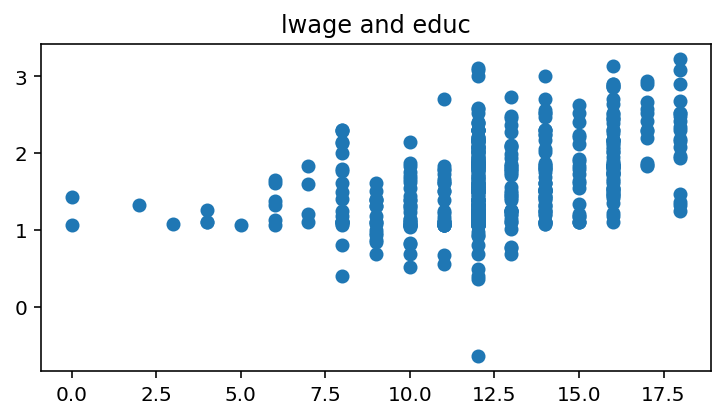

In [8]:
plt.rcParams['figure.figsize'] = [6,3]  # figure size
plt.scatter(df.educ, df.lwage)
plt.title('lwage and educ')
plt.show()

단순회귀를 한 결과는 다음과 같다.

In [9]:
ols = smf.ols('lwage~educ', data=df).fit()
print(ols.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.184
No. Observations:                 526   F-statistic:                     119.6
Covariance Type:            nonrobust   Prob (F-statistic):           3.27e-25
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.097      5.998      0.000       0.393       0.775
educ           0.0827      0.008     10.935      0.000       0.068       0.098

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


회귀 결과는 $\widehat{\log(wage)} = 0.5383 + 0.0827 educ$, 즉 절편은 0.5383, 기울기는 0.0827이다. 산포도에 OLS 회귀선을 추가하여 그리면 다음과 같다. 직선은 [matplotlib.pyplot.axline][axline]을 이용하여 그린다.

[axline]: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axline.html

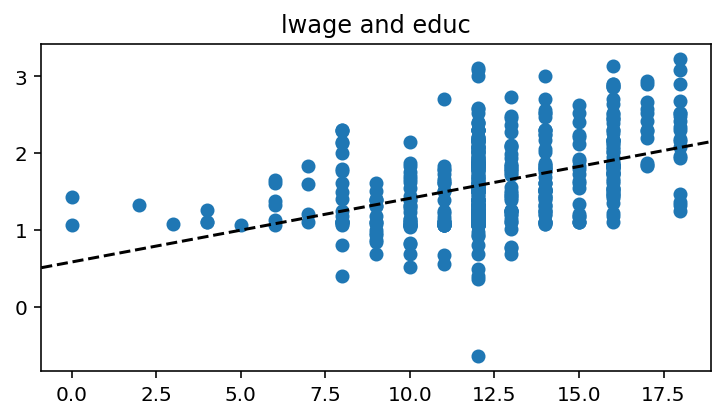

In [10]:
plt.scatter(df.educ, df.lwage)
plt.title('lwage and educ')
b0,b1 = ols.params
plt.axline((0,b0), slope = b1, color='black', ls='--')
plt.show()

### axline의 문제점

위 그림은 특별해서 문제가 나타나지 않지만, [matplotlib.pyplot.axline][axline] 함수를 이용하여 직선을 그릴 때 문제가 있다.
```python
plt.axline((0, b0), slope=b1)
```
과 같이 직선을 그리면 `(0, b0)` 점이 들어오도록 축이 자동으로 조정된다. 이는 상당히 불편할 수 있다. 다음 예를 보라. x값의 평균이 50이 되도록 데이터를 생성하고 그림을 그리면 다음과 같다(직선은 안 그림).

[axline]: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axline.html

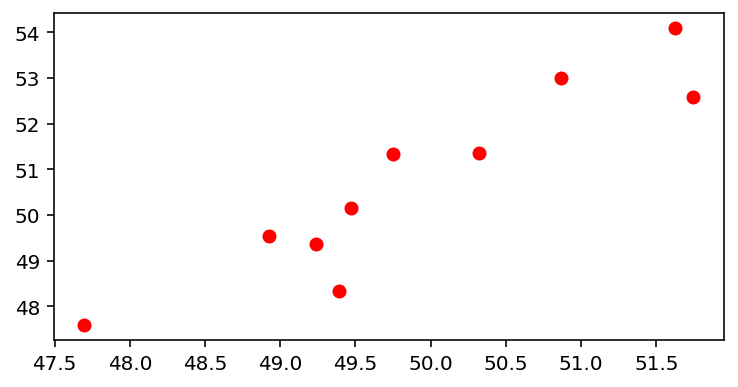

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6, 3]
%config InlineBackend.figure_format = "retina"

# simulated sample with n=10
np.random.seed(1)
x = np.random.normal(loc=50, size=10)
y = 1+x+np.random.normal(size=10)
plt.plot(x, y, 'ro')
plt.show()

위 그림에서 X축은 약 47.5\~52 범위로 표시되고 Y축은 약 47.5\~54 범위로 표시되었다. 이제 직선을 덧그리기 위해 `y`를 `x`에 대하여 회귀해 보자.

In [12]:
import statsmodels.api as sm

ols = sm.OLS(y,sm.add_constant(x)).fit()
ols.params

array([-26.61865726,   1.55005002])

절편 추정값은 (소수점 아래 셋째 자리로 반올림하여) -26.619, 기울기 추정값은 1.550이다. 이제 위 그림에 OLS 회귀선을 덧그려 보자.

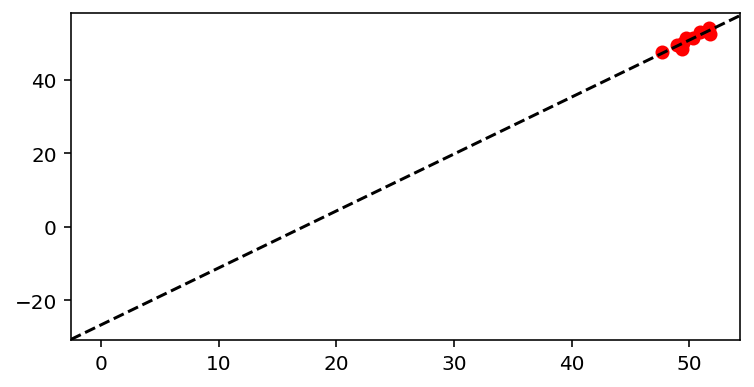

In [13]:
b0, b1 = ols.params
plt.plot(x, y, 'ro')
plt.axline((0, b0), slope = b1, color = 'black', ls='--')
plt.show()

위 그림에서 절편에 해당하는 (0, b0) 좌표 그림 안에 들어오도록 X축과 Y축의 범위가 조정된 것을 볼 수 있다. 이런 그림은 우리가 원하는 바가 아니다. 이 문제를 해결할 한 가지 방법은 일일이 눈으로 확인하고 축 범위(`xlim`과 `ylim`)를 조정해 주는 것인데, 이 방법은 경우에 따라 사용할 수 있겠으나 대부분의 경우 불편하다. 그냥 처음에 자동으로 그려진 그림 위에 직선만 얹고 싶다.

한 가지 해결책은 산포도(scatter plot)를 그린 다음 `xlim`과 `ylim`을 이용하여 축의 범위를 고정시키는 것이다. 다음 코드를 사용하면 된다.

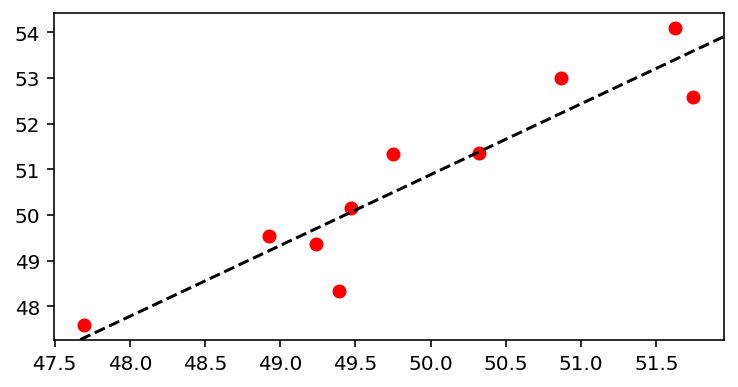

In [14]:
plt.plot(x, y, 'ro')
## https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
# We need this to fixate the limits of plots
plt.xlim(plt.gca().get_xlim()) # fix xlim
plt.ylim(plt.gca().get_ylim()) # fix ylim
plt.axline((0, b0), slope = b1, color = 'black', ls='--')
plt.show()

원래 그림 위에 직선만 덧그려진 것을 확인할 수 있다. `bok` 패키지에서는 위와 같이 `xlim`과 `ylim`을 고정하는 것을 `plt.fix_lims()`와 같이 호출하도록 구현해 두었다.

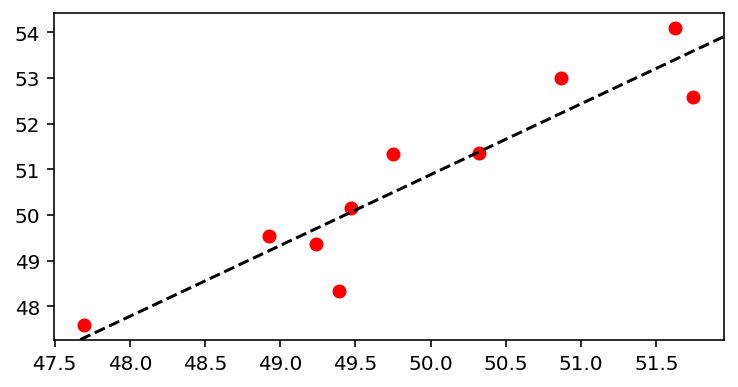

In [15]:
import bok_da

plt.plot(x, y, 'ro')
plt.fix_lims()
plt.axline((0, b0), slope = b1, color = 'black', ls='--')
plt.show()

더 수학적인 방법으로서, 절편을 $(0, b_0)$으로 표시하는 것이 아니라 $(\bar{x}, b_0 + b_1 \bar{x})$로 표시하는 복잡한 방법도 있겠으나 이런 수학을 사용하기보다는 `bok` 패키지에서 제공하는 `plt.fix_lims()`를 이용하여 축을 고정하는 편이 더 간편하다.

## Collinearity

공선성(collinearity)이 있을 때 원래 [statsmodels][sm] 패키지의 디폴트 옵션은 Moore-Penrose 역행렬(pseudo inverse)을 사용하여 마치 아무 문제도 없는 듯한 결과를 제공한다. 이런 이상한 일이 발생하지 않도록 하려면 [statsmodels][sm] OLS 모듈의 `fit` 메쏘드에 pseudo inverse ("pinv") 대신에 QR ("qr") 방법을 사용하도록 하는 옵션(method="qr")도 존재하나, 공선성이 존재하면 오류를 발생시킨다는 문제가 있다. 선형 추세, 많은 더미변수, 상호작용항 등이 있는 모형에서 공선성은 매우 빈번히 발생하는 현상 중 하나이며, 공선성이 존재하지 않는 모형을 탐색하는 것도 쉽지 않을 수 있으므로 자동으로 변수를 누락시키고 공선성이 없는 모형을 추정해 주는 것은 계량경제 분석에서 매우 중요하다. [Stata]와 [R]은 이 기능을 제공한다.

본 프로젝트를 위하여 monkey patch된 `statsmodels` 패키지에서는 `statsmodels.tools.collinearity` 모듈을 제공하고 이 모듈 내 `check` 함수는 회귀식 우변에 공선성이 있는지 점검하고 유지할 열, 제외시킬 열, 원래 변수 리스트를 리턴한다.

[R]: https://r-project.org/
[Stata]: https://stata.com/
[sm]: https://www.statsmodels.org/

In [17]:
import statsmodels.api as sm
from statsmodels.tools import collinearity
import pandas as pd

df = pd.read_stata('data/wage1.dta')
df['prev_exper'] = df.exper - df.tenure
df['derived_age'] = df.educ + df.exper + 6
fm = 'lwage~educ+exper+expersq+tenure+prev_exper+derived_age'
keep,drop,vlist = collinearity.check(fm, data=df)
keep,drop,vlist

(['Intercept', 'educ', 'exper', 'expersq', 'tenure'],
 ['prev_exper', 'derived_age'],
 ['Intercept',
  'educ',
  'exper',
  'expersq',
  'tenure',
  'prev_exper',
  'derived_age'])

위에서 `exper`, `tenure`, `prev_exper` 간에는 서로 완전한 공선성 관계가 있고, `educ`, `exper`, `derived_age` 간에 완전한 공선성 관계가 있으므로 변수들이 누락되어야 한다. 위 결과를 보면 `prev_exper`와 `derived_age` 변수가 누락됨을 알 수 있다. `keep`, `drop` 부분에 변수명 대신 변수의 인덱스(0부터 시작)를 리턴하고자 한다면 다음과 같이 할 수 있다.

In [13]:
collinearity.check(fm, data=df, ret_names=False)

([0, 1, 2, 3, 4],
 [5, 6],
 ['Intercept',
  'educ',
  'exper',
  'expersq',
  'tenure',
  'prev_exper',
  'derived_age'])

monkey patch된 statsmodels 패키지의 `RegressionModel.fit()` 메쏘드는 디폴트 `method`를 "pinv"로부터 "qr"로 변경하고, `check_collinearity = False` 인자가 주어지지 않으면 공선성을 점검하도록 작성되어 있다. 반면 원래 statsmodels 패키지에서는 pseudo inverse를 사용하고 공선성 점검을 하지 않는다. 만약 위의 공선성 있는 모형을 원래 statsmodels 패키지에서 디폴트로 사용되는 방법 그대로 추정하면 다음 결과를 얻는다.

In [14]:
mod = sm.OLS.from_formula(fm, data=df)
print(mod.fit(method = 'pinv', check_collinearity = False).summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                      0.3595
Model:                            OLS   Adj. R-squared:                 0.3545
No. Observations:                 526   F-statistic:                     73.09
Covariance Type:            nonrobust   Prob (F-statistic):             0.0000
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -0.00404    0.00819      -0.49      0.622    -0.02013     0.01205
educ           0.05162    0.02238       2.31      0.021     0.00766     0.09558
exper          0.00636    0.01175       0.54      0.588    -0.01672     0.02944
expersq       -0.00066    0.00011      -5.94      0.000    -0.00088    -0.00044
tenure         0.01360    0.00596       2.28      0.023     0.00189     0.02531
prev_exper    -0.00724    0.00616      -1.17 

놀랍게도 모든 변수들에 대하여 결과가 매우 그럴 듯하게 나온다. 하지만 이는 공선성을 무시하고 pseudo inverse를 사용하였기 때문에 얻은 잘못된 결과이다. 위 Notes의 \[2\]에 공선성을 암시하는 주석이 있으나, 사용자들이 항상 이러한 주석에 주의를 기울일 것으로 기대할 수는 없다.

"pinv" 대신에 "qr" 방법을 사용하면 공선성에 관하여 조금 더 informative하지만 여전히 모든 변수를 사용한 결과를 얻는다. 어떤 때에는 에러가 발생하기도 한다. 셀을 재실행하면 정상출력된다.

In [16]:
print(mod.fit(check_collinearity = False).summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                      0.3584
Model:                            OLS   Adj. R-squared:                 0.3534
No. Observations:                 526   F-statistic:                     72.75
Covariance Type:            nonrobust   Prob (F-statistic):             0.0000
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    1.2891e+13    0.00820    1.6e+15      0.000  1.2891e+13  1.2891e+13
educ         2.1484e+12    0.02239    9.6e+13      0.000  2.1484e+12  2.1484e+12
exper        6.6675e+12    0.01176    5.7e+14      0.000  6.6675e+12  6.6675e+12
expersq        -0.00066    0.00011      -5.96      0.000    -0.00088    -0.00044
tenure       -4.519e+12    0.00597   -7.6e+14      0.000  -4.519e+12  -4.519e+12
prev_exper   -4.519e+12    0.00617   -

다행히도 경고 문구도 나오고 계수 추정값이 10의 12승이라는 아주 큰 숫자가 나오는 등 뭔가 잘못되었다는 느낌을 준다. 하지만 이 결과로부터는 어느 변수가 공선성을 야기하는지, 어느 변수들을 제외시켜야 공선성 문제가 해결되는지에 대한 정보를 얻을 수 없다.

monkey patch된 statsmodels 패키지에서는 디폴트로 공선성 점검을 한 후 문제가 되는 변수들을 누락하고 OLS 추정을 한다. 결과는 다음과 같다. 공선성을 야기하는 변수들을 적절히 제외시킨 회귀 결과를 제공함을 알 수 있다.

In [17]:
print(mod.fit().summary(slim=True))

note: prev_exper omitted because of collinearity.
note: derived_age omitted because of collinearity.
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                      0.3595
Model:                            OLS   Adj. R-squared:                 0.3545
No. Observations:                 526   F-statistic:                     73.09
Covariance Type:            nonrobust   Prob (F-statistic):             0.0000
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     0.19834    0.10196       1.95      0.052    -0.00195     0.39864
educ          0.08535    0.00719      11.87      0.000     0.07123     0.09947
exper         0.03285    0.00511       6.42      0.000     0.02281     0.04290
expersq      -0.00066    0.00011      -5.94      0.000    -0.00088    -0.00044
tenure        0.02084    0.003

주의: 공선성 문제 해결은 model에서 데이터를 수정하는 방식으로 이루어지므로, `mod.check_collinearity()`나 `mod.fit()`을 일단 실행하고 나면 공선성을 야기하는 변수들은 모형에서 삭제된다. 그러므로 그 다음에 `mod.fit(collinearity_check=False)`라고 하여도 `prev_exper` 변수는 사용되지 않는다.

In [18]:
mod = sm.OLS.from_formula(fm, data=df)
mod.check_collinearity(quiet = True)
print(mod.dropped_names)
mod.check_collinearity(quiet = True)
print(mod.dropped_names)

['prev_exper', 'derived_age']
[]


위에서 두 번째 `check_collinearity`는 아무런 변수도 누락시키지 않는데, 이는 첫 번째 `check_collinearity` 명령에 의하여 공선성을 야기하는 변수들이 이미 제외되었기 때문이다.